In [1]:
!pip install langchain openai tiktoken pypdf huggingface-hub sentence_transformers InstructorEmbedding faiss-cpu python-dotenv


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
import os

OPENAI_API_KEY = str(os.getenv('OPENAI_API_KEY'))
PINECONE_API_KEY = str(os.getenv('PINECONE_API_KEY'))
PINECONE_API_ENV = str(os.getenv('PINECONE_API_ENV'))

root_dir = ""

In [24]:
# Required libraries
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import DirectoryLoader
from langchain.callbacks import get_openai_callback

In [10]:
loader = DirectoryLoader("data/", glob="./*.pdf")
documents = loader.load()

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

texts = text_splitter.split_documents(documents)

In [17]:
texts[177]

Document(page_content='26 - 2 26 - 3\n\n30 - 1 30 - 3\n\n30 - 3 30 - 3\n\n30 - 5\n\n9803/3280\n\nIssue 1\n\nPurchased from www.WorkshopManuals.co.uk\n\nwww.WorkshopManuals.co.uk Body & Framework\n\nSection B\n\nii\n\nSection B\n\nii\n\nContents\n\nPage No.\n\nLoader Arms - Removal and Replacement\n\nStabiliser Legs - Removal and Replacement\n\nKingpost - Removal and Replacement\n\nBoom & Dipper - Removal and Replacement\n\nHydraulic Tank - Removal and Replacement\n\nPower Sideshift Ram Removal and Replacement\n\n\n\nCab Panels - Removal and Replacement Side Console Front/Steering Console\n\n35 - 1\n\n36 - 1\n\n37 - 1\n\n38 - 1\n\n39 - 1\n\n40 - 1\n\n50 - 1 51 - 1\n\n9803/3280\n\nIssue 2*\n\nPurchased from www.WorkshopManuals.co.uk\n\nSection B\n\n1 - 1\n\nwww.WorkshopManuals.co.uk Body & Framework\n\nService Tools\n\nSection B\n\n1 - 1\n\nCartridge Gun - hand operated - essential for the application of sealants, polyurethane materials etc.\n\npart\n\nJCB 892/00845\n\nnumber\n\n\n\nHand

### Create embeddings of your documents to get ready for semantic search

In [13]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Pinecone, Chroma

import pinecone

In [14]:
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

In [18]:
# Initialize pinecone

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_API_ENV
)

pinecone.create_index('jcbdata', dimension=1536, metric="cosine")

index_name="jcbdata"

In [19]:
%%time
vecstore = Pinecone.from_texts([t.page_content for t in texts], embeddings, index_name=index_name)

CPU times: total: 4.31 s
Wall time: 5min 12s


In [20]:
question = 'What is a JCB?'
docs = vecstore.similarity_search(question)

In [21]:
docs

[Document(page_content="To utilise any supporting ShiftMaster Service Tools requires the use of the JCB Data Link Adaptor (DLA) which is part of the standard JCB Electronic Service Tool Kit, part number 892/01033.\n\nThis software is intended for use on IBM Compatible Personal Computers (PCs) running Windows 9x or Windows2000 operating systems but is not compatible with either earlier versions of Windows 3.x.\n\nIt is known that some laptop PCs can experience problems with serial communications.\n\nIn a few rare cases the PCs hardware does not allow the diagnostics software access to communications (COM) ports.\n\nJCB Service are the process of compiling a 'recommended' list of laptops which we know to work satisfactorily with JCB Software.\n\nin\n\nIn the majority of cases conflicts are caused by either software already running on the PC, or by certain 'driver' files which hog the COM port(s).\n\nNote: a PC which has many users and uses is likely to contain some redundant software and

### Using OpenAI as LLM to query with the custom docs.

In [23]:
qa = RetrievalQA.from_chain_type(
    llm=OpenAI(),
    chain_type="stuff",
    retriever=vecstore.as_retriever()
)

In [28]:
def query(q):
    print('Question: ', q)
    with get_openai_callback() as cb:
        print('Answer: ', qa.run(q))
        print(cb)

In [29]:
query('I have some issue in my gear box, what do you suggest?')

Question:  I have some issue in my gear box, what do you suggest?
Answer:   It sounds like you are having some issues with your gearbox. It is best to start by performing a thorough inspection of all components. Be sure to check for signs of excessive wear or damage and make sure that all oil way cross drillings in the casings, shafts and gears are clear and free from debris. You can also check the 1st/2nd gear synchro unit by dismantling the unit and checking the cones and rings, balls, poppets, and springs. If any components are found to be worn or damaged, they should be replaced.
Tokens Used: 1329
	Prompt Tokens: 1214
	Completion Tokens: 115
Successful Requests: 1
Total Cost (USD): $0.02658


In [30]:
query('Issue in my Excavator Valve')

Question:  Issue in my Excavator Valve
Answer:   If you are having an issue with your excavator valve, it could be caused by contamination, damage to spools, damage to seal grooves, worn or damaged O-rings and back-up rings, scratches, pitting, or corrosion. To start troubleshooting, inspect the valve components for any of these issues, clean and renew components as applicable, and lubricate parts with hydraulic fluid before assembling. Be sure to fit the filter gauze the correct way round. If necessary, adjust, repair, or renew components as required.
Tokens Used: 1093
	Prompt Tokens: 985
	Completion Tokens: 108
Successful Requests: 1
Total Cost (USD): $0.021859999999999997


In [32]:
query('Steps to replace the Evaporator Matrix in my air conditioning.')

Question:  Steps to replace the Evaporator Matrix in my air conditioning.
Answer:   Disconnect the battery, gain access to the HVAC unit by removing the right hand side console and remove the HVAC unit top cover, refer to HVAC/Air Conditioning Unit - Removal and Replacement Steps 2 and 3. Unclip evaporator and gently remove the wire from between the fins. Drain the refrigerant from the unit and remove all pipe work (refrigerant and air) which will prevent the unit from being withdrawn from the machine. Carefully lift the evaporator matrix complete with expansion valve T from the housing, bearing in mind that a certain amount of resistance will be met due to the stiction from the sealing putty. Replacement is the reverse of the removal procedure.
Tokens Used: 1228
	Prompt Tokens: 1086
	Completion Tokens: 142
Successful Requests: 1
Total Cost (USD): $0.02456


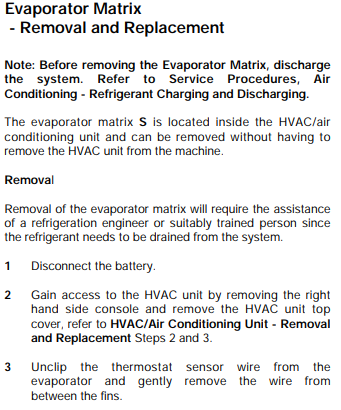

In [33]:
query('Steps to dismantle the Steering Column. Write the steps in points.')

Question:  Steps to dismantle the Steering Column. Write the steps in points.
Answer:   
1. Using a screwdriver in the slot, carefully prise out the dust seal L from the outer column tube. 
2. Remove external circlip M, washer N, tolerance ring P and withdraw the steering shaft from the outer column tube and pivot bracket.
3. Note: The top and bottom bearings R and S housed in the outer column tube are non serviceable parts. They may be removed for cleaning and inspection, but if the bearing(s) have failed a new outer column tube and pivot bracket assembly must be used.
4. Note: The gas damper strut E is a non serviceable part. If the damper is faulty it must be replaced with a new one.
Tokens Used: 1261
	Prompt Tokens: 1115
	Completion Tokens: 146
Successful Requests: 1
Total Cost (USD): $0.02522


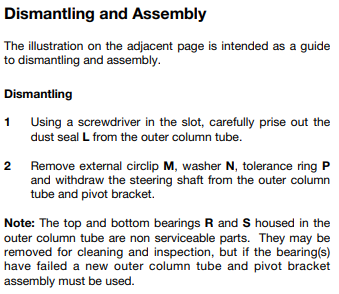

In [36]:
query('How to remove the Master Cylinder and Servo Unit? Write the steps in points.')

Question:  How to remove the Master Cylinder and Servo Unit? Write the steps in points.
Answer:  

1 Gain access the the brake pedal box assembly. Remove the steering wheel, column switches and console assembly. See Section D, Steering Column - Removal for procedures.
2 Working outside the cab, loosen and remove brake pipe unions B, plug and cap to prevent loss of fluid and ingress of dirt.
3 Remove the brake pipes from the master cylinders: master cylinders bridging pipe D; axle feed pipes E and reservoir supply pipes H.
4 Working inside the cab, remove the brake pedals clevis F and disengage the brake pedal from the servo unit (both pedals).
5 Loosen and remove the servo unit retaining nuts G (both units).
6 Tag the cylinders (left and right hand). Remove the master cylinder and servo units.
Tokens Used: 1251
	Prompt Tokens: 1093
	Completion Tokens: 158
Successful Requests: 1
Total Cost (USD): $0.02502


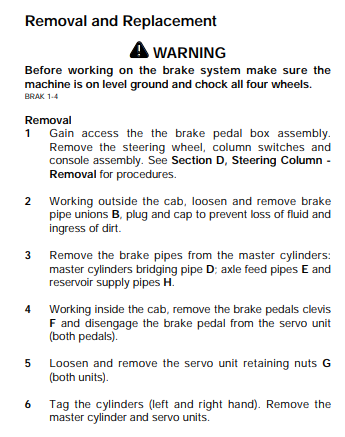